In [1]:
from scipy.spatial.transform import Rotation as R
import json
import numpy as np

def create_homogeneous_matrix(xyz, quaternion):
    rotation_matrix = R.from_quat(quaternion).as_matrix()
    T = np.eye(4) 
    T[:3, :3] = rotation_matrix
    T[:3, 3] = xyz 

    return T

def pose_inv(pose):
    R = pose[:3, :3]
    T = np.eye(4)
    T[:3, :3] = R.T
    T[:3, 3] = - R.T @ np.ascontiguousarray(pose[:3, 3])
    return T


K = np.load("handeye/intrinsics_d415.npy")
T_WC = np.load("handeye/T_WC_head.npy")
DIR = "scissor"

with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
    
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])
demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
demo_waypoints

array([[ 0.50418126,  0.09185436,  0.48143709, -0.99837866,  0.01344973,
        -0.05489271,  0.00677801],
       [ 0.53294318, -0.23440121,  0.46487699, -0.98059457, -0.0403039 ,
        -0.01228236,  0.19146549],
       [ 0.39427   ,  0.10932387,  0.34613448,  0.98784625,  0.00202494,
         0.04185784,  0.14967836],
       [ 0.51934571, -0.08409991,  0.34498188, -0.98729532, -0.08079432,
        -0.0286418 ,  0.13379041],
       [ 0.39427   ,  0.10932387,  0.44613448,  0.98784625,  0.00202494,
         0.04185784,  0.14967836],
       [ 0.51934571, -0.08409991,  0.44981884, -0.98729532, -0.08079432,
        -0.0286418 ,  0.13379041]])

In [2]:
a = R.from_quat(demo_waypoints[0][3:]).as_euler("xyz")
a

array([-3.12649077, -0.10964465, -0.02777028])

In [2]:
point_2Ds = []

for i in range(len(demo_waypoints)):
    point3d = pose_inv(T_WC)  @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K, point3d[:3, 3])
    
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)

point_2Ds

[array([859.99596727, 289.76787131]),
 array([403.47195629, 307.10154953]),
 array([776.96720408, 363.52071681]),
 array([628.59192212, 460.00380598]),
 array([789.857792  , 250.19352658]),
 array([629.63972625, 329.44544132])]

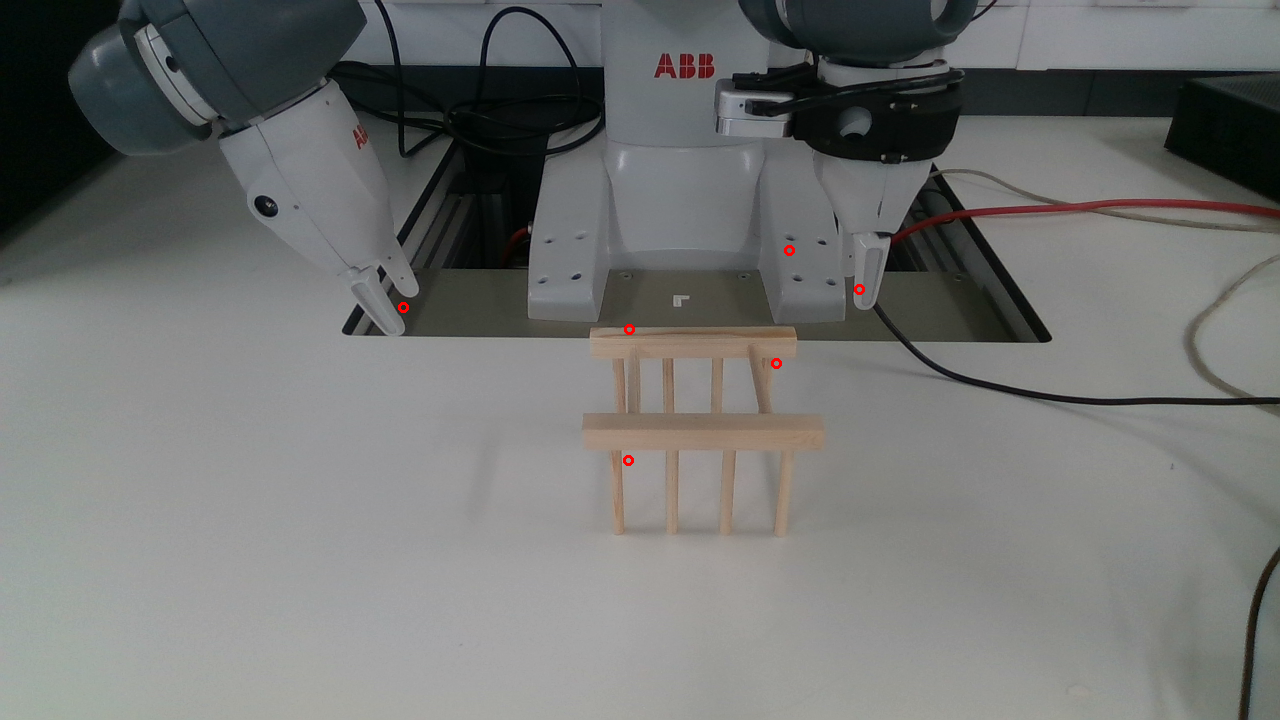

In [3]:
from PIL import Image, ImageDraw

head_rgb = Image.open(f"experiments/{DIR}/demo_head_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(head_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
head_rgb

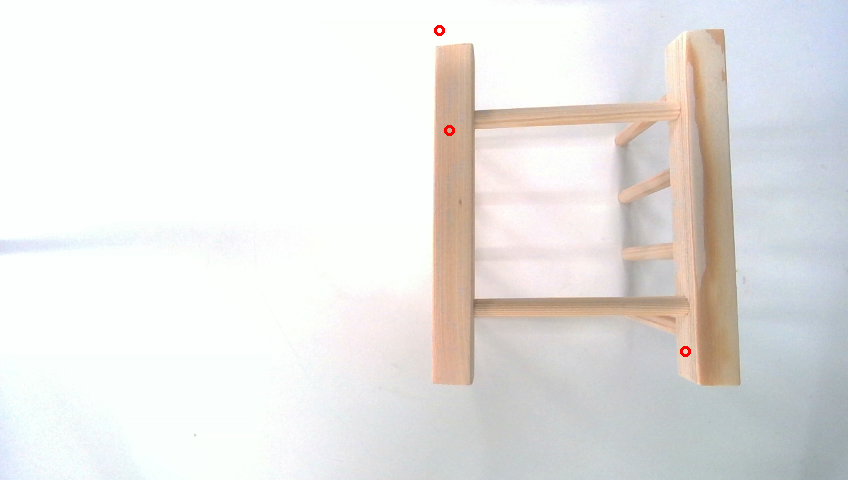

In [4]:
with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
    
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])
demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
demo_waypoints

K_wrist = np.load("handeye/intrinsics_d405.npy")
T_C_EEF = np.load("handeye/T_C_EEF_wrist_l.npy")
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])
point_2Ds = []
T_EEF_World = create_homogeneous_matrix(demo_waypoints[0, :3], demo_waypoints[0, 3:])
for i in range(len(demo_waypoints)):

    point3d = pose_inv(T_C_EEF) @ pose_inv(T_EEF_World) @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K_wrist, point3d[:3, 3])
    
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)

wrist_rgb = Image.open(f"experiments/{DIR}/demo_wrist_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

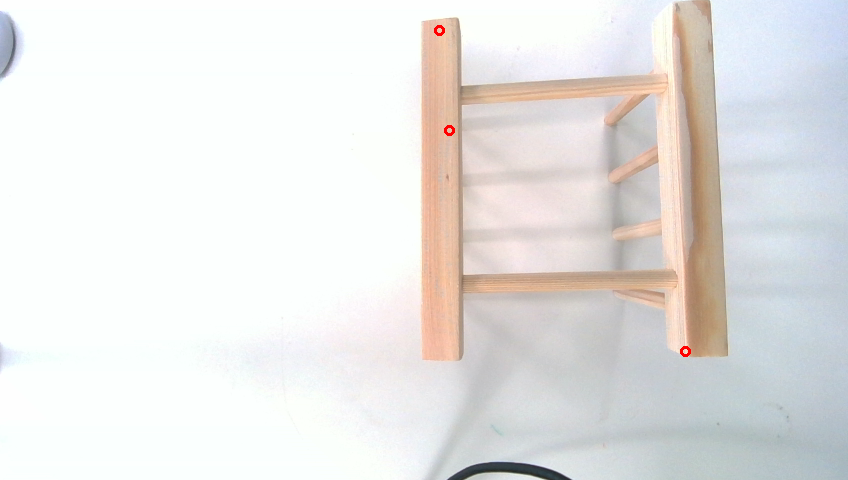

In [15]:
wrist_rgb = Image.open(f"experiments/{DIR}/live_d405_rgb.png")

draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

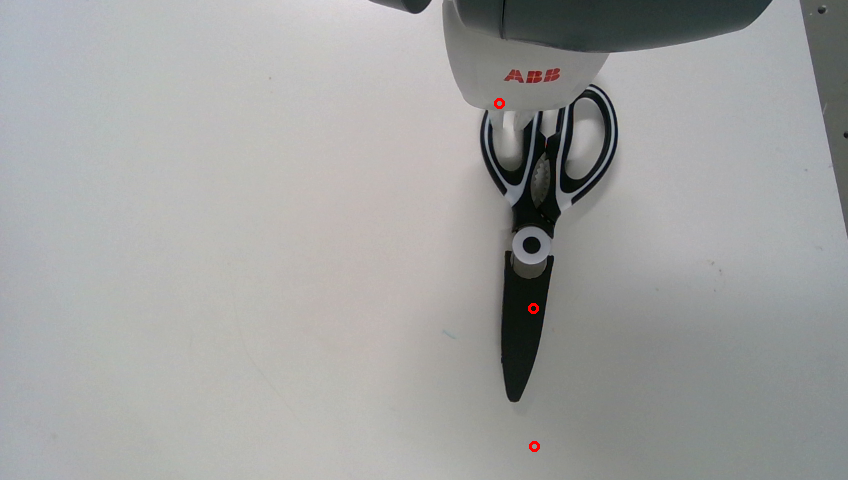

In [8]:
wrist_rgb = Image.open(f"experiments/{DIR}/live_right_in_view.png")

draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

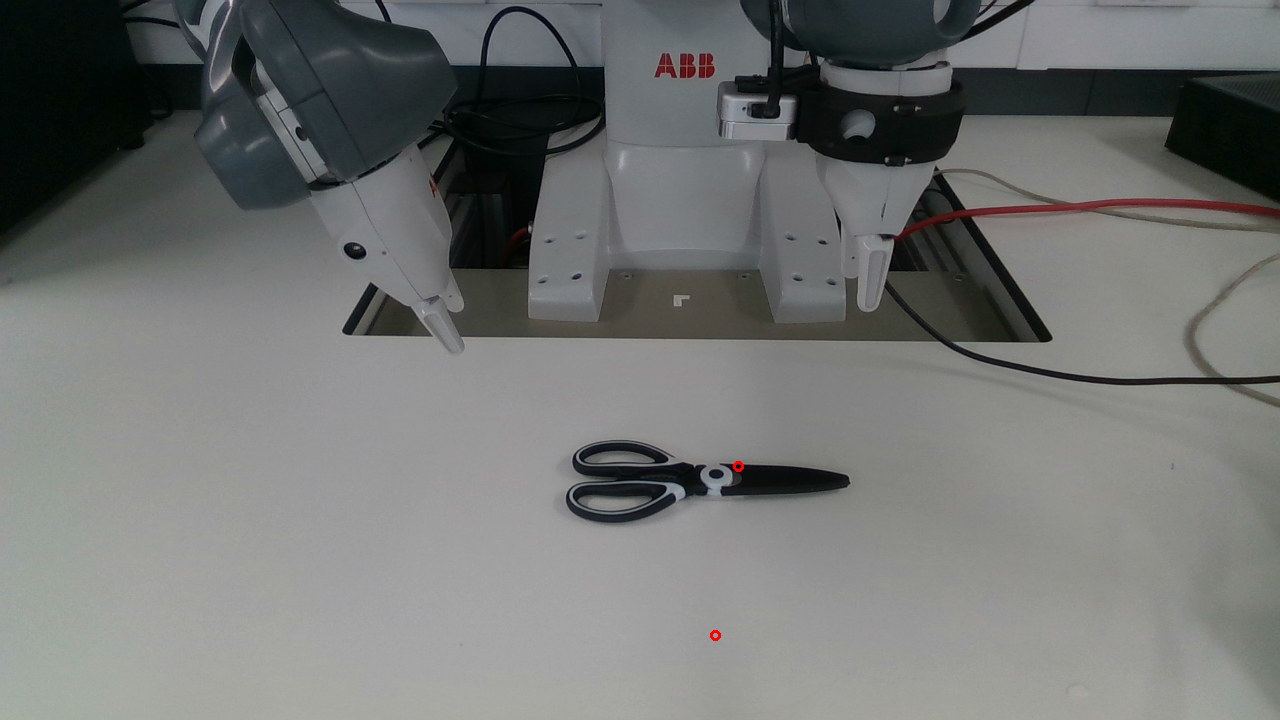

In [16]:
from PIL import Image, ImageDraw

head_rgb = Image.open(f"experiments/{DIR}/demo_head_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(head_rgb)

for point_2D in [[738, 466], [715, 635], [800, 910]]:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
head_rgb